## 2. Feature Engineering on Time-Series Data for Human Activity Recognition

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.8.30 </div>
<div style="text-align: right\"> Last update: 2021.8.30</div>

- 출처 : https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60

In [107]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from scipy.signal import find_peaks

In [108]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In this article, we will be exploring different techniques to transform the raw time-series data and extract new features from it.

### About data  
스마트폰이나 워치에는 tri-axial accelerometers를 지니고 있어 3차원 가속도를 측정 가능.

본 데이터는 WISDM Lab에서 제공하는 것임 [(link)](https://www.cis.fordham.edu/wisdm/dataset.php)

데이터는 36명으로부터 추출한 패턴(걷기, 계단오르기, 계단 내려가기, 앉기, 서있기)등을 기록한 것이다. 데이터는 50ms마다 수집되었고, 다시말해 초당 20샘플이다.  
데이터의 각 feature는 다음과 같다.  
- ‘user’, ‘timestamp’, ‘x-axis’, ‘y-axis’, and ‘z-axis’ 
타겟은 'activity' 컬럼이다.  

timestamp는 나노초 단위로 기록된다.

### Data cleasing and preprocessing

- drop null values  
- change the datatype of the ‘z-axis’ column to float.
- drop the rows where the timestamp is 0.
- sort data in ascending order of the user and timestamp.

**주의**: 데이터에 문제있음 라인 수정해야 정상적으로 읽어짐

In [109]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']

In [110]:
df = pd.read_csv('data/wisdom/WISDM_ar_v1.1_raw.txt', header = None, names=columns, on_bad_lines='skip')

In [111]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [112]:
df.tail()

,user,activity,timestamp,x-axis,y-axis,z-axis
1086461,19,Sitting,131623331483000,9.00,-1.57,1.69;
1086462,19,Sitting,131623371431000,9.04,-1.46,1.73;
1086463,19,Sitting,131623411592000,9.08,-1.38,1.69;
1086464,19,Sitting,131623491487000,9.00,-1.46,1.73;
1086465,19,Sitting,131623531465000,8.88,-1.33,1.61;


In [113]:
df.shape

(1086466, 6)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086466 entries, 0 to 1086465
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086466 non-null  int64  
 1   activity   1086466 non-null  object 
 2   timestamp  1086466 non-null  int64  
 3   x-axis     1086466 non-null  float64
 4   y-axis     1086466 non-null  float64
 5   z-axis     1086465 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 49.7+ MB


In [115]:
# df['z-axis']= df['z-axis'].str[:-1].astype('float64')

In [116]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [117]:
df.isnull().sum()

user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64

In [118]:
df[df['z-axis'].isnull()]

,user,activity,timestamp,x-axis,y-axis,z-axis
343413,11,Walking,1867172313000,4.4,4.4,NaN


결측치 제거

In [119]:
df = df.dropna()

In [120]:
df.shape

(1086465, 6)

z-axis 컬럼을 실수형으로 변환

In [121]:
df['z-axis'] = df['z-axis'].str.replace(';', '')
df['z-axis'] = df['z-axis'].apply(lambda x: float(x))

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086465 entries, 0 to 1086465
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086465 non-null  int64  
 1   activity   1086465 non-null  object 
 2   timestamp  1086465 non-null  int64  
 3   x-axis     1086465 non-null  float64
 4   y-axis     1086465 non-null  float64
 5   z-axis     1086465 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


timestamp가 0인 열 제거

In [123]:
df.describe()

,user,timestamp,x-axis,y-axis,z-axis
count,1.086465e+06,1.086465e+06,1.086465e+06,1.086465e+06,1.086465e+06
mean,1.883756e+01,3.250279e+13,6.641130e-01,7.246045e+00,3.976974e-01
std,1.026681e+01,4.893650e+13,6.876277e+00,6.739789e+00,4.761111e+00
min,1.000000e+00,0.000000e+00,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,1.000000e+01,1.999712e+12,-2.910000e+00,3.170000e+00,-2.220117e+00
50%,1.900000e+01,9.396203e+12,2.700000e-01,7.930000e+00,0.000000e+00
75%,2.800000e+01,3.509473e+13,4.440000e+00,1.156000e+01,2.720000e+00
max,3.600000e+01,2.093974e+14,1.995000e+01,2.004000e+01,1.961000e+01


In [124]:
df[df['timestamp']==0]

,user,activity,timestamp,x-axis,y-axis,z-axis
14398,20,Walking,0,0.0,0.0,0.0
14399,20,Walking,0,0.0,0.0,0.0
14643,20,Walking,0,0.0,0.0,0.0
14644,20,Walking,0,0.0,0.0,0.0
14645,20,Walking,0,0.0,0.0,0.0
...,...,...,...,...,...,...
870639,3,Walking,0,0.0,0.0,0.0
870640,3,Walking,0,0.0,0.0,0.0
926475,22,Downstairs,0,0.0,0.0,0.0
926476,22,Downstairs,0,0.0,0.0,0.0


In [125]:
df = df[df['timestamp']!=0]

데이터 정렬

In [126]:
df = df.sort_values(by = ['user', 'timestamp'], ignore_index = True)

In [127]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


### EDA

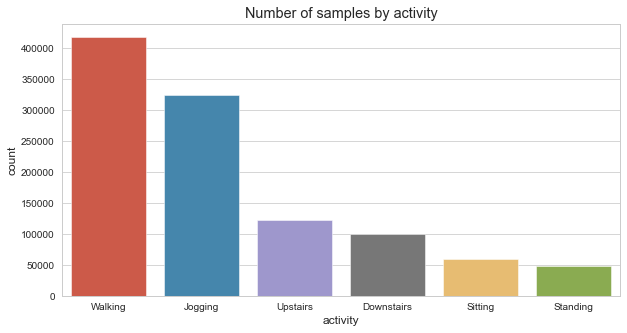

In [128]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

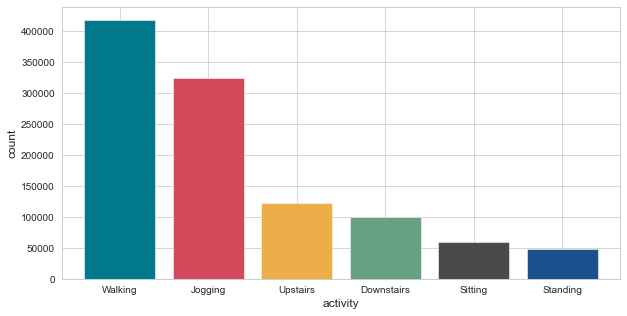

In [129]:
plt.figure(figsize = (10, 5))
df['activity'].value_counts().plot(kind = 'bar', color = colors, rot= 0, 
                                   width = 0.8)
plt.xlabel('activity')
plt.ylabel('count')
plt.show()

- 행동별 빈도 차이가 있다.  
- class imbalance

사용자별 행동 빈도수 비교

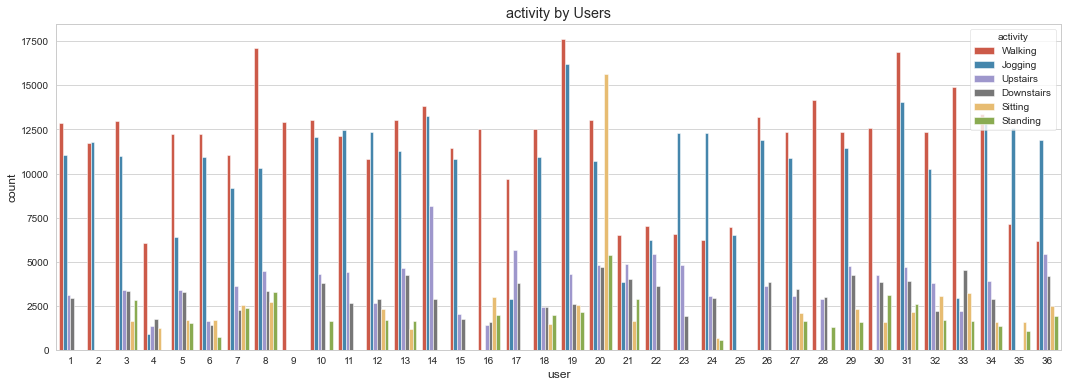

In [130]:
plt.figure(figsize=(18, 6))
sns.countplot(x= 'user', hue = 'activity', data = df)
plt.title('activity by Users')
plt.show()

In [131]:
df.groupby('user')['activity'].value_counts()

user  activity  
1     Walking       12861
      Jogging       11056
      Upstairs       3120
      Downstairs     2941
2     Jogging       11786
                    ...  
36    Walking        6200
      Upstairs       5429
      Downstairs     4167
      Sitting        2500
      Standing       1925
Name: activity, Length: 179, dtype: int64

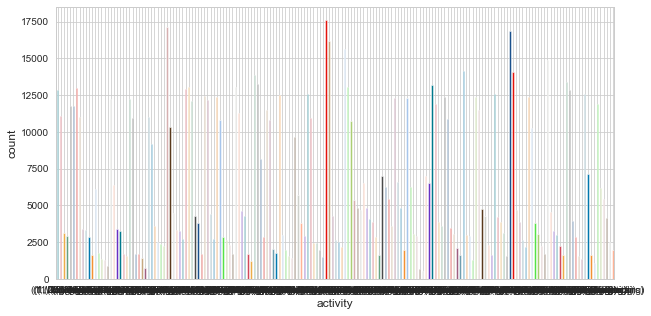

In [132]:
plt.figure(figsize = (10, 5))
df.groupby('user')['activity'].value_counts().plot(kind = 'bar', color = colors, rot= 0, 
                                   width = 0.4)
plt.xlabel('activity')
plt.ylabel('count')
plt.show()

- 개별 사용자가 전체 활동을 하지 않았다. 활동별 빈도도 사람마다 다양하다. 하지만 데이터 샘플수가 많기 때문에 전체 결과에 영향을 미치지 않는다.  
다시 말해 모든 사용자의 행동이 유사하다고 봐도 무방하다.

이제 특정사용자의 측정 값을 살펴보자

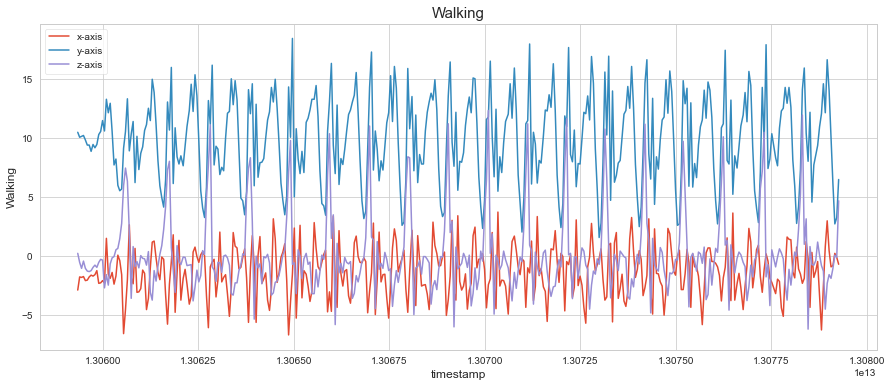

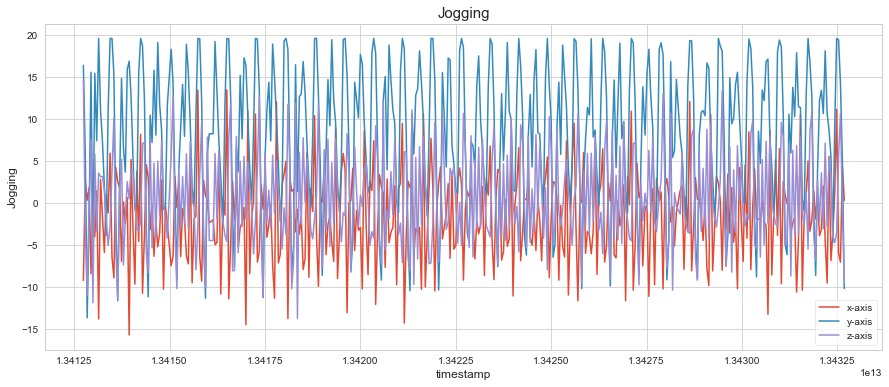

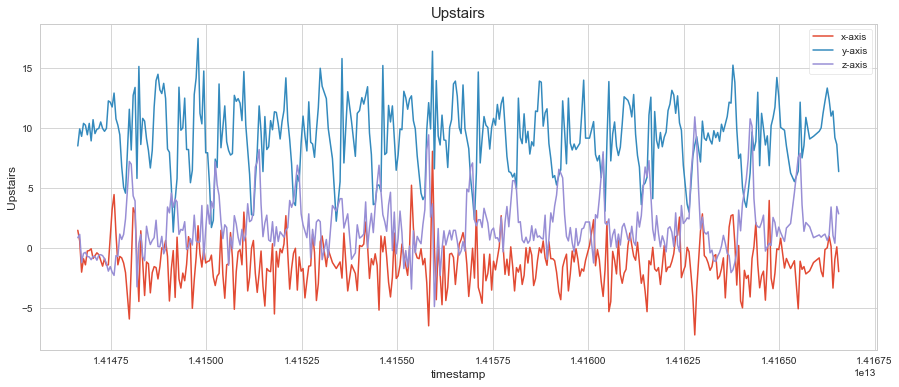

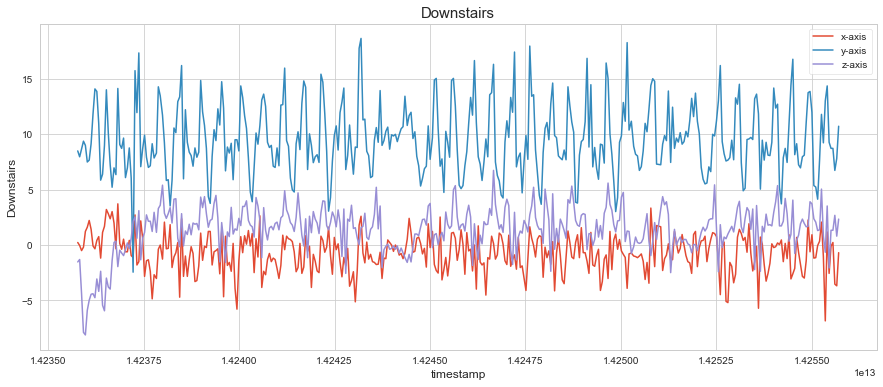

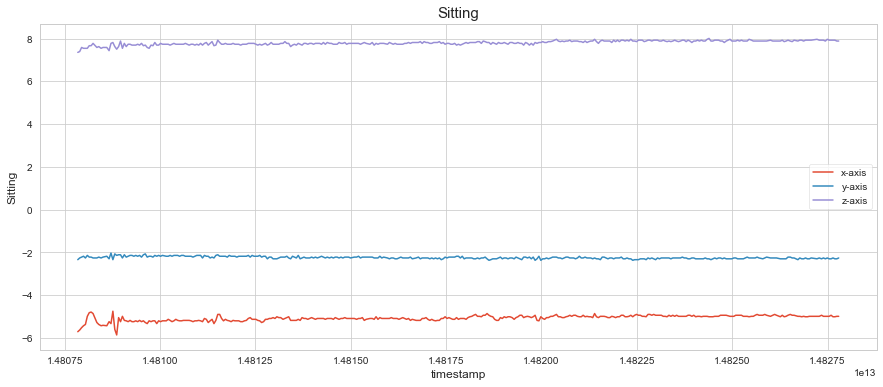

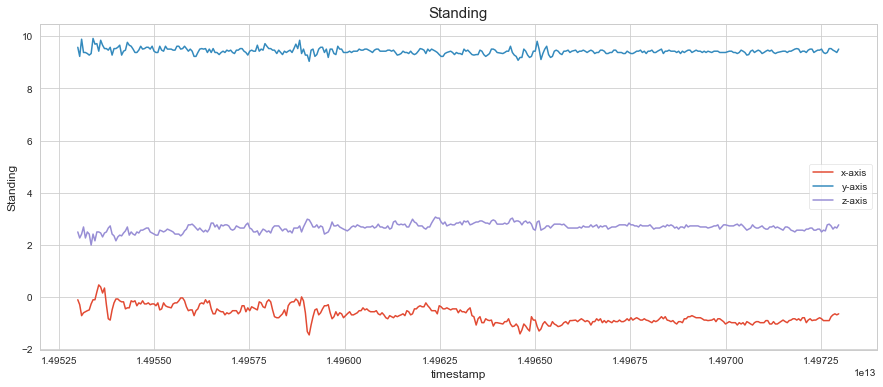

In [133]:
for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']:
    data36 = df[(df['user']==36) & (df['activity']==i)][:400]
    plt.figure(figsize = (15, 6))
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

<Figure size 1080x432 with 0 Axes>

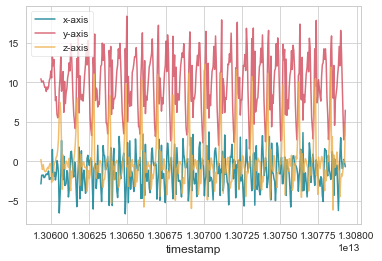

<Figure size 1080x432 with 0 Axes>

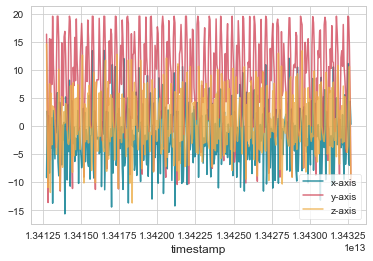

<Figure size 1080x432 with 0 Axes>

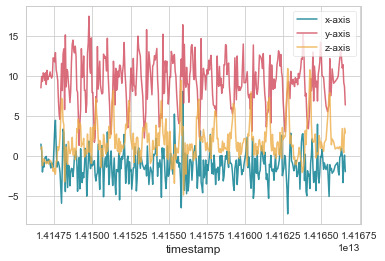

<Figure size 1080x432 with 0 Axes>

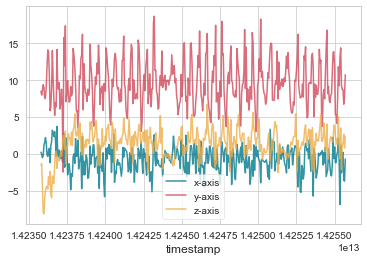

<Figure size 1080x432 with 0 Axes>

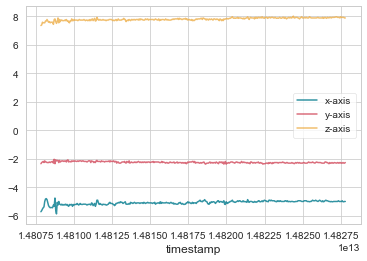

<Figure size 1080x432 with 0 Axes>

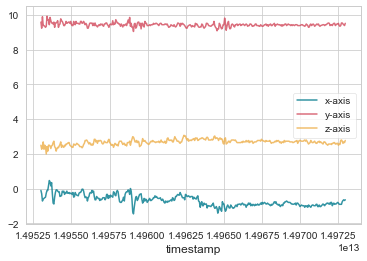

In [134]:
for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']:
    data36 = df[(df['user']==36) & (df['activity']==i)][:400]
    plt.figure(figsize = (15, 6))
    data36.set_index('timestamp')[['x-axis', 'y-axis', 'z-axis']].plot(color = colors, alpha = 0.8)
    plt.show()

- 400샘플은 20초간 기록한 값이다.  
- 차트에서 보는 바와 같이 Walking, Jogging, Upstairs and Downstairs는 주기 특성을 보인다.  
- Sitting, Standing은 움직임이 약하다.

이제 각 activity 별 측정 값 분포를 살펴보자.  
- facetgrid 참고자료  
    - https://steadiness-193.tistory.com/201
    - https://data-newbie.tistory.com/537

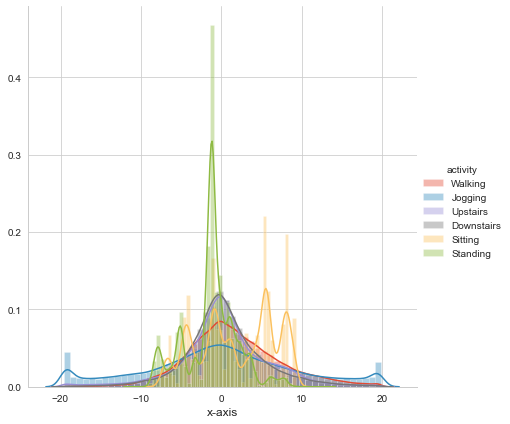

In [135]:
sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'x-axis').add_legend()

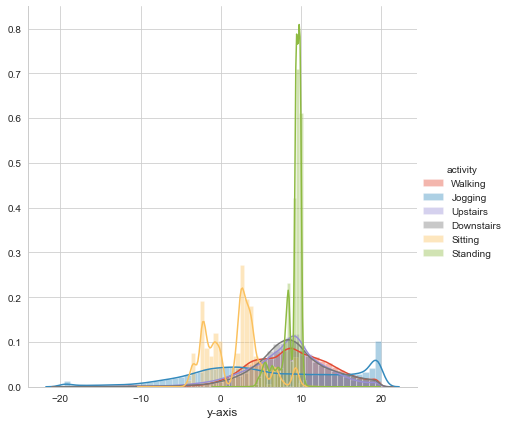

In [136]:
sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'y-axis').add_legend()

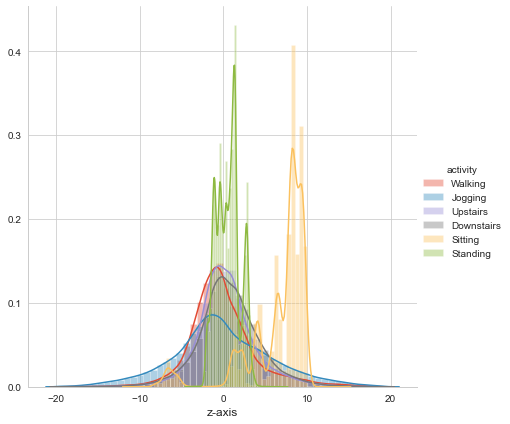

In [137]:
sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'z-axis').add_legend()

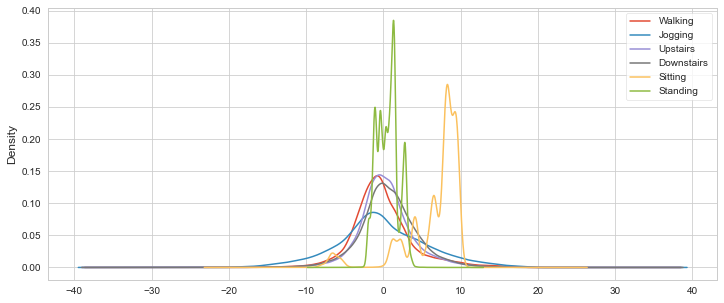

In [138]:
fig, ax = plt.subplots(figsize = (12, 5))
for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']:
    df.loc[df['activity']==i, 'z-axis'].plot(kind = 'kde', label = i, ax = ax)
plt.legend()
plt.show()

### Data Transformation

데이터를 windowing 기법을 사용하여 변환한다.  
 - 데이터를 5초 간격으로 쪼갠 후, 100개의 sample을 병합하여 새 피처를 만든다.  
 - For assigning class-label against the transformed features, we take the most frequent activity in that window.

예를 들어 데이터가 100row이고 window size가 50이면, 작업 후의 데이터 row 크기는 2가 된다.   
그리고 이 두 row의 레이블은 가장 빈번하게 나타나는 행동으로 정한다.

You must be wondering why a 5 sec window is chosen. After going through several literature, I felt that it could be the optimal window-size we can consider for capturing the repetitive motions involved in most of the six activities. Too less window-size may not capture the motion correctly, while too large window-size results in less datapoints in transformed dataset for training.

또한가지 고려할 사항 :  
    discrete 윈도우를 사용하지 않고, 50%를 오버랩한다.  
    This ensures that every subsequent row in the transformed dataset has some information from the data in previous window as well.

All this above featurization might sound little daunting at first, but trust me, it is not that complicated. Read this section again slowly, because if you understand this well, the subsequent sections are going to be a cakewalk. Here I’m attaching this image, it will help you get a clear idea of how raw signal data is aggregated and transformed into new features.

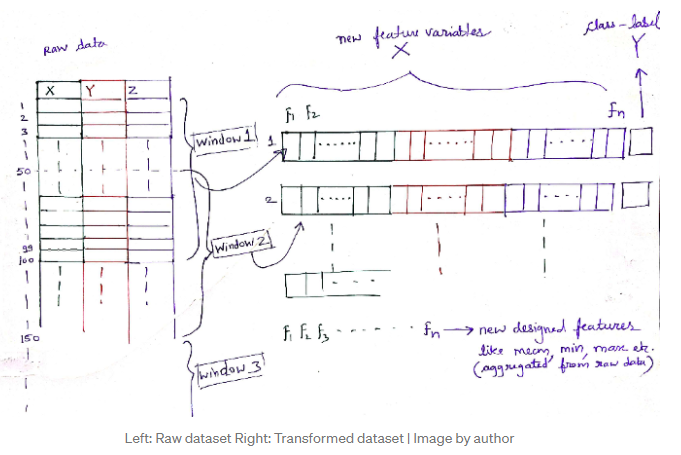

### Feature engineering

시작하기전에 데이터를 Train, Test용으로 구분한다.  
일반적으로 random split를 하지만, 여기서는 UserID 단위로 나누는 것이 적절하다.

예를 들어 36명의 사용자 중에 27명의 사용자 데이터를 학습용으로 9명의 것을 시험용으로 쓴다면,,

```python
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df[‘user’] <= 27]
# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df[‘user’] > 27]
```

In [139]:
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user'] <= 27]
# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user'] > 27]

In [140]:
df_train.shape

(792622, 6)

In [141]:
df_test.shape

(281001, 6)

By doing this, we get about 804358 data samples in training set and 281002 samples in the test set. This is just like doing 75–25 split, but in a more sophisticated manner.

### Feature Engineering Stage 1: Statistical measures

아래와 같은 간단한 통계로 피처를 만들 수 있다.

1. mean
2. standard deviation
3. average absolute deviation
4. minimum value
5. maximum value
6. difference of maximum and minimum values
7. median
8. median absolute deviation
9. interquartile range
10. negative values count
11. positive values count
12. number of values above mean
13. number of peaks
14. skewness
15. kurtosis
16. energy
17. average resultant acceleration
18. signal magnitude area

- **Energy** of a signal in every axis is computed by taking the mean of sum of squares of the values in a window in that particular axis.  
- **Average resultant acceleration over the window** is computed by taking average of the square roots of the values in each of the three axis squared and added together.  
- **Signal magnitude area** is defined as the sum of absolute values of the three axis averaged over a window.

In [160]:
x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 100
step_size = 50

In [161]:
# creating overlaping windows of size 100  
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x-axis'].values[i : i + 100]
    ys = df_train['y-axis'].values[i : i + 100]
    zs = df_train['z-axis'].values[i : i + 100]
    label = stats.mode(df_train['activity'][i: i + 100])[0][0] # 가장 빈도가 높은 것에 레이블링

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [162]:
x_list

[array([ 0.69,  6.85,  0.93, -2.11, -4.59, 12.41, 17.27,  1.42, -2.68,
        -1.38,  1.57,  4.02,  4.94,  4.75,  3.34,  2.6 ,  7.31,  8.43,
        10.53,  6.66,  2.49, -1.12,  0.  ,  7.16, -0.8 , -5.13, -3.17,
        19.57,  7.08,  0.15, -1.99,  0.65,  3.49,  4.18,  2.98,  2.07,
         4.29,  6.74, 10.92,  9.51,  4.52,  2.91,  2.49,  2.34,  0.99,
        -2.18, -6.66, 10.61, 17.43,  1.08, -3.17, -2.03,  2.64,  5.6 ,
         7.25,  4.44,  3.15,  2.83,  5.98, 11.6 , 12.07,  5.79,  1.95,
        -1.12,  3.95,  2.15, -2.22, -7.35, 12.91, 15.75, -2.11, -3.34,
        -1.88,  3.38,  6.02,  4.79,  2.45,  1.14,  5.41,  7.89, 12.11,
        10.8 ,  4.02,  1.18,  0.  ,  1.54, -0.19, -4.63, -4.75, 19.57,
         7.06, -0.72, -2.68,  0.93,  3.91,  5.05,  5.48,  3.53,  3.53,
         8.16]),
 array([-3.17, -2.03,  2.64,  5.6 ,  7.25,  4.44,  3.15,  2.83,  5.98,
        11.6 , 12.07,  5.79,  1.95, -1.12,  3.95,  2.15, -2.22, -7.35,
        12.91, 15.75, -2.11, -3.34, -1.88,  3.38,  6.02,  4.

In [163]:
pd.Series(x_list)

0        [0.69, 6.85, 0.93, -2.11, -4.59, 12.41, 17.27,...
1        [-3.17, -2.03, 2.64, 5.6, 7.25, 4.44, 3.15, 2....
2        [11.88, 12.57, 6.74, 2.91, -0.11, 4.67, 0.57, ...
3        [-2.79, -8.24, 17.35, 13.25, 3.21, -3.21, -1.9...
4        [6.17, 4.82, 3.6, 6.09, 10.38, 12.64, 7.16, 2....
                               ...                        
15846    [0.23, 0.23, -0.72, -0.23, 0.93, 1.73, 0.76, -...
15847    [0.34, 0.65, 0.31, 0.15, 0.34, 0.31, 0.5, 0.19...
15848    [-0.34, -0.69, -0.19, 0.93, 1.33, -0.3, -0.38,...
15849    [0.38, 0.42, 0.42, 0.69, 0.84, 0.84, 0.65, 0.5...
15850    [0.38, 0.65, 0.31, 0.15, 0.42, 0.69, 1.04, 0.9...
Length: 15851, dtype: object

In [164]:
pd.Series(x_list).apply(lambda x : x.mean())

0        3.6538
1        3.8267
2        3.8955
3        4.0975
4        3.8653
          ...  
15846    0.3747
15847    0.3484
15848    0.5435
15849    0.6316
15850    0.6246
Length: 15851, dtype: float64

In [165]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

In [166]:
X_train.shape

(15851, 50)

In [167]:
df_train.shape

(792622, 6)

In [168]:
int(df_train.shape[0]/50)-1

15851

Each of the x_list, y_list and z_list is actually a list of the windows.  
Each of these windows consists of 100 observations.  
So shall have a total of int(792622/50) -1 = 15851 windows (you can verify this is from code).  
X_train is our new feature dataframe built from the transformed features.  
Henceforth, we shall now be using this new dataframe, and progressively adding new features to it and eventually using it for training ML models.

### Feature Engineering Stage 2: Fast-Fourier transform (FFT)

퓨리에 변환은 시간영역 시그널을 주파수 도메인으로 변환시켜 준다.   
FT가 신호를 변환하는 것이 아니라 사실은 데이터분석의 다른 관점을 제공해주는 것이다.

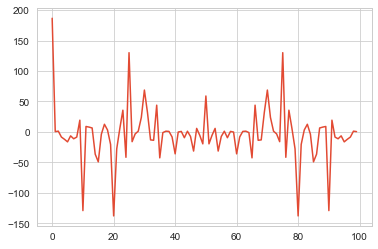

In [169]:
pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.show()

- 위 42번째 샘플을 보면 첫번째 값이 비정상적으로 높은 것을 알 수 있다.   
- 이부분은 저주파 영역으로 DC 값이다.   
- 그외에 신호는 중심을 기준으로 대칭이다.

저주파 영역은 무시하자. 일반적으로 높고, 정보가 없다.  
나머지 1~50까지의 절반부분만 상요하자.(대칭이므로)  

이부분에 통계적 특징이 많을 것으로 보인다.

In [170]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])# 저주파 0 제외, 100개중 절반만 사용
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

### Feature Engineering Stage 3: Capturing indices

In [171]:
# Max Indices and Min indices 

# index of max value in time domain
X_train['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
X_train['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
X_train['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

# index of min value in time domain
X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

# absolute difference between above indices
X_train['x_arg_diff'] = abs(X_train['x_argmax'] - X_train['x_argmin'])
X_train['y_arg_diff'] = abs(X_train['y_argmax'] - X_train['y_argmin'])
X_train['z_arg_diff'] = abs(X_train['z_argmax'] - X_train['z_argmin'])

# index of max value in frequency domain
X_train['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

# index of min value in frequency domain
X_train['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

# absolute difference between above indices
X_train['x_arg_diff_fft'] = abs(X_train['x_argmax_fft'] - X_train['x_argmin_fft'])
X_train['y_arg_diff_fft'] = abs(X_train['y_argmax_fft'] - X_train['y_argmin_fft'])
X_train['z_arg_diff_fft'] = abs(X_train['z_argmax_fft'] - X_train['z_argmin_fft'])

### 테스트 데이터 만들기

In [172]:
x_list = []
y_list = []
z_list = []
test_labels = []

window_size = 100
step_size = 50

for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x-axis'].values[i : i + 100]
    ys = df_test['y-axis'].values[i : i + 100]
    zs = df_test['z-axis'].values[i : i + 100]
    label = stats.mode(df_test['activity'][i: i + 100])[0][0] # 가장 빈도가 높은 것에 레이블링

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

In [173]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

In [174]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])# 저주파 0 제외, 100개중 절반만 사용
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [175]:
# Max Indices and Min indices 

# index of max value in time domain
X_test['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
X_test['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
X_test['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

# index of min value in time domain
X_test['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
X_test['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
X_test['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

# absolute difference between above indices
X_test['x_arg_diff'] = abs(X_test['x_argmax'] - X_test['x_argmin'])
X_test['y_arg_diff'] = abs(X_test['y_argmax'] - X_test['y_argmin'])
X_test['z_arg_diff'] = abs(X_test['z_argmax'] - X_test['z_argmin'])

# index of max value in frequency domain
X_test['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_test['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_test['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

# index of min value in frequency domain
X_test['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_test['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_test['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

# absolute difference between above indices
X_test['x_arg_diff_fft'] = abs(X_test['x_argmax_fft'] - X_test['x_argmin_fft'])
X_test['y_arg_diff_fft'] = abs(X_test['y_argmax_fft'] - X_test['y_argmin_fft'])
X_test['z_arg_diff_fft'] = abs(X_test['z_argmax_fft'] - X_test['z_argmin_fft'])

### Implementing a Linear model for Activity Prediction

In [176]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [178]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)

In [179]:
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8259476775226908

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.63      0.77      0.69       575
     Jogging       0.82      0.94      0.87      1523
     Sitting       0.86      0.99      0.92       361
    Standing       0.92      0.82      0.87       325
    Upstairs       0.63      0.57      0.60       639
     Walking       0.95      0.81      0.87      2196

    accuracy                           0.83      5619
   macro avg       0.80      0.82      0.80      5619
weighted avg       0.84      0.83      0.83      5619



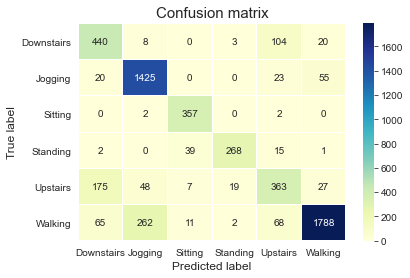

In [184]:
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('Confusion matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()